Import required libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from pymongo import MongoClient
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import ast
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import copy
from skill_classifier import SkillClassifier
import spacy
from sentence_transformers import SentenceTransformer

d:\Projects\ai-resume-parser\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LM Studio and MongoDb configuration

In [2]:
# --- LMStudio CONFIG ---
API_URL = "http://127.0.0.1:1234/v1/embeddings"
EMBEDDING_DIM = 768

client = MongoClient("mongodb://localhost:27017/")
db = client["jobs_data"]
collection = db["jobs"]

Loading Data from MongoDb

In [3]:
print("Fetching job data from MongoDB...")
data = list(collection.find(
    {"core_position": {"$exists": True}, "core_skills": {"$exists": True, "$ne": []}},
    {"core_position": 1, "core_skills": 1, "text": 1, "_id": 0}
))
df = pd.DataFrame(data)

Fetching job data from MongoDB...


Cleaning skills

In [ ]:
print("Cleaning skill lists...")
nlp = spacy.load("en_core_web_sm")
def clean_skills(skill_list):
    if not isinstance(skill_list, list):
        return []
    cleaned_skills = []
    for skill in skill_list:
        if isinstance(skill, str):
            doc = nlp(skill.lower().strip())
            for token in doc:
                if token.pos_ in ['NOUN', 'PROPN']:
                    cleaned_skills.append(token.text)
    return cleaned_skills

df["core_skills_cleaned"] = df["core_skills"].apply(clean_skills)

# --- Filter rare skills (keep skills used in ≥5 jobs) ---
print("Filtering rare skills...")
flat_skills = [s for sublist in df["core_skills_cleaned"] for s in sublist]
skill_counts = Counter(flat_skills)
common_skills = set([s for s, count in skill_counts.items() if count >= 5])

df["filtered_skills"] = df["core_skills_cleaned"].apply(lambda skills: [s for s in skills if s in common_skills])
df = df[df["filtered_skills"].str.len() > 0]  # Drop rows with no common skills
# df["filtered_skills"] = df["filtered_skills"].apply(ast.literal_eval)
df.to_csv("models/cleaned_job_data.csv", index=False)

Cleaning skill lists...
Filtering rare skills...


OSError: Cannot save file into a non-existent directory: 'feedback_component'

In [6]:
df.to_csv("models/cleaned_job_data.csv", index=False)

In [4]:
df = pd.read_csv("models/cleaned_job_data.csv")
df["filtered_skills"] = df["filtered_skills"].apply(ast.literal_eval)

Embed job titles with descriptions using LM Studio

In [5]:
# --- 5. Embed job titles using LM Studio ---
def get_embedding(text):
    payload = {
        "input": text,
        "model": "text-embedding-nomic-embed-text-v1.5"
    }
    try:
        response = requests.post(API_URL, json=payload).json()
        return np.array(response["data"][0]["embedding"])
    except Exception as e:
        print(f"Error embedding '{text}': {e}")
        return np.zeros(EMBEDDING_DIM)

def get_avg_embedding(text, chunk_size=300):
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    embeddings = [get_embedding(chunk) for chunk in chunks]
    return np.mean(embeddings, axis=0)

In [ ]:
X = np.stack(
    df.apply(lambda row: get_avg_embedding(f"{row['core_position']}. {row['text']}"), axis=1)
)
with open("models/job_title_embeddings.npy", "wb") as f:
    np.save(f, X)

Cluster skills

In [16]:
# Flatten and count
print("Counting skills...")
flat_skills = [skill for sublist in df["filtered_skills"] for skill in sublist]
skill_counts = Counter(flat_skills)

# Get top N skills (optional)
all_skills = [s for s, count in skill_counts.items()]

print("Generating embeddings for skills...")
sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")
skill_embeddings = sentence_transformer.encode(all_skills)

print("Clustering skills...")
dbscan = DBSCAN(eps=0.3, min_samples=2, metric="cosine")
labels = dbscan.fit_predict(skill_embeddings)

# Create mapping
print("Creating mappping...")
skill_cluster_df = pd.DataFrame({"skill": all_skills, "cluster": labels})

canonical_map = {}
grouped = skill_cluster_df.groupby("cluster")["skill"]

for cluster_id, group in grouped:
    if cluster_id == -1:  # noise, skip or keep as-is
        for skill in group:
            canonical_map[skill] = skill
    else:
        # Use most frequent term or the first one
        canonical_skill = group.iloc[0]
        for skill in group:
            canonical_map[skill] = canonical_skill

standardized_skills = []
for skill_list in df["filtered_skills"]:
    clean = [canonical_map.get(s, s) for s in skill_list]
    standardized_skills.append(clean)

Counting skills...
Generating embeddings for skills...
Clustering skills...
Creating mappping...


Encode skills

In [17]:
import joblib

# --- Multi-label encode skills ---
print("Multi-label encoding skills...")
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(standardized_skills)
print("Loaded skill label count:", len(mlb.classes_))

# Save the encoded skills matrix Y
with open("models/skill_encoded_matrix.npy", "wb") as f:
    np.save(f, Y)
    
joblib.dump(mlb, 'models/skill_label_binarizer.joblib')

print(mlb.classes_)
print("✅ Saved skill label binarizer with", len(mlb.classes_), "skills")

Multi-label encoding skills...
Loaded skill label count: 3039
['#' '%' '+' ... 'zoo' 'zoology' 'zoom']
✅ Saved skill label binarizer with 3039 skills


Load saved models

In [5]:
X = np.load("models/job_title_embeddings.npy")
Y = np.load("models/skill_encoded_matrix.npy")

In [6]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (33042, 768)
Y shape: (33042, 3039)


Train model

In [7]:
# Convert data
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, Y_train = X_train.to(device), Y_train.to(device)

skill_classifier_model = SkillClassifier(X.shape[1], Y.shape[1]).to(device)

# Train
optimizer = optim.AdamW(skill_classifier_model.parameters(), lr=0.003, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_fn = nn.BCELoss()

best_f1 = 0.0
patience = 5
wait = 0
best_model_state = None

for epoch in range(50):
    skill_classifier_model.train()
    optimizer.zero_grad()
    outputs = skill_classifier_model(X_train)
    loss = loss_fn(outputs, Y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Validation F1 (Top-K = 5 by default for early stopping)
    skill_classifier_model.eval()
    with torch.no_grad():
        val_outputs = skill_classifier_model(X_test)
        preds = torch.zeros_like(val_outputs)
        topk_indices = torch.topk(val_outputs, 5, dim=1).indices
        for i, row in enumerate(topk_indices):
            preds[i, row] = 1

    f1 = f1_score(Y_test.cpu(), preds.cpu(), average="micro")

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        wait = 0
        best_model_state = copy.deepcopy(skill_classifier_model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}.")
            break

print(f"✅ Best F1 (Top-K=5): {best_f1:.4f}")

# Save best model
model_path = f"models/skill_model.pth"
torch.save(best_model_state, model_path)
print(f"📦 Model saved to {model_path}")

⏹️ Early stopping triggered at epoch 18.
✅ Best F1 (Top-K=5): 0.2398
📦 Model saved to models/skill_model.pth


Load Model

In [8]:
# Load best model for final Top-K evaluations
model_path = f"models/skill_model.pth"
skill_classifier_model.load_state_dict(torch.load(model_path))
skill_classifier_model.eval()

SkillClassifier(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=3039, bias=True)
    (8): Sigmoid()
  )
)

Evaluate model

In [19]:
results = []

for top_k in [3, 5, 6, 7, 10]:
    with torch.no_grad():
        outputs = skill_classifier_model(X_test)
        preds = torch.zeros_like(outputs)
        topk_indices = torch.topk(outputs, top_k, dim=1).indices
        for i, row in enumerate(topk_indices):
            preds[i, row] = 1

    f1 = f1_score(Y_test.cpu(), preds.cpu(), average="micro")
    precision = precision_score(Y_test.cpu(), preds.cpu(), average="micro")
    recall = recall_score(Y_test.cpu(), preds.cpu(), average="micro")

    results.append({"Top K": top_k, "F1 (micro)": f1, "Precision": precision, "Recall": recall})

# Convert results to a dataframe
results_df = pd.DataFrame(results)
results_df

Top K,F1 (micro),Precision,Recall
3,0.178799,0.657992,0.103456
5,0.239778,0.577394,0.151306
6,0.249246,0.520931,0.163812
7,0.261283,0.486739,0.178570
10,0.293290,0.426449,0.223502


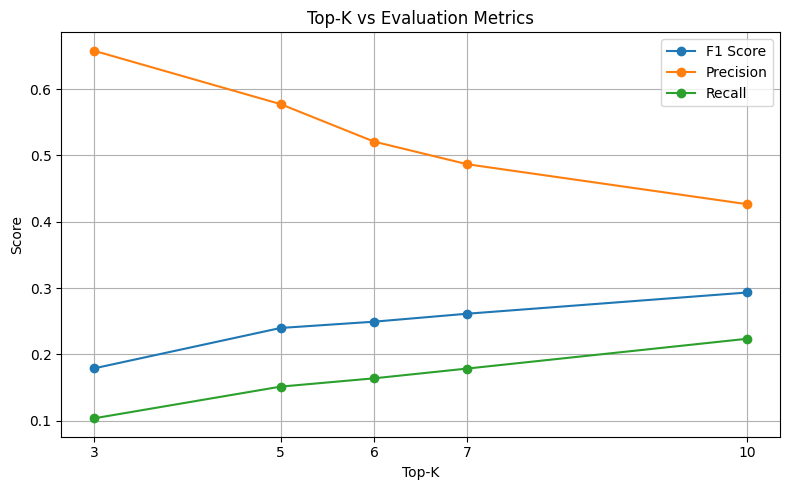

In [15]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 5))
plt.plot(results_df['Top K'], results_df['F1 (micro)'], marker='o', label='F1 Score')
plt.plot(results_df['Top K'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['Top K'], results_df['Recall'], marker='o', label='Recall')

# Formatting
plt.title('Top-K vs Evaluation Metrics')
plt.xlabel('Top-K')
plt.ylabel('Score')
plt.xticks(results_df['Top K'])
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show
plt.show()


Testing

In [20]:
def recommend_skills_from_summary(job_title: str, summary: str, top_k: int = 6):
    # Combine and embed input
    input_text = f"{job_title}. {summary}"
    embedding = get_embedding(input_text)
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32).to(device).unsqueeze(0)

    # Predict and extract top-k indices
    with torch.no_grad():
        outputs = skill_classifier_model(embedding_tensor)
        topk_indices = torch.topk(outputs, top_k, dim=1).indices[0].cpu().numpy()

    # Map indices back to skill labels
    predicted_skills = [mlb.classes_[i] for i in topk_indices]
    return predicted_skills

job_title = "Data Scientist"
summary = "Experienced in analyzing large datasets, building machine learning models, and presenting insights to stakeholders."

recommended_skills = recommend_skills_from_summary(job_title, summary, top_k=5)
print("🔧 Suggested Skills:", recommended_skills)

NameError: name 'get_embedding' is not defined